# Training a CVAE model on MNIST

In this notebook, we demonstrate how to train a Conditional Variational Autoencoder (CVAE) model on the dataset MNIST. 


In [1]:
from multivae.data.datasets.mnist_labels import MnistLabels
from torch.utils.data import random_split

data_path = '/Users/agathe/dev/data'

trainset = MnistLabels(data_path,split='train',download=False )
trainset, evalset = random_split(trainset, [0.8, 0.2])
testset = MnistLabels(data_path,split='test',download=False )


/Users/agathe/dev/multivae_package/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train the model with default architectures

In this section, we use the default MLP architectures for the CVAE model. 
First we define the model configuration and instantiate the model. 

In [2]:
from multivae.models import CVAE, CVAEConfig

model_config = CVAEConfig(
    latent_dim=16,
    input_dims=dict(images=(1, 28, 28), labels=(10,)),
    conditioning_modality='labels',
    main_modality='images',
    decoder_dist='bernoulli'
)
    
model = CVAE(model_config)

Then we instantiate the trainer and train the model.

In [4]:
from multivae.trainers import BaseTrainer, BaseTrainerConfig

trainer_config = BaseTrainerConfig(
    output_dir='/Users/agathe/dev/expes',
    learning_rate=1e-3,
    per_device_eval_batch_size=128,
    per_device_train_batch_size=128,
    num_epochs=1)

trainer=BaseTrainer(
    model=model,
    train_dataset=trainset,
    eval_dataset=evalset,
    training_config=trainer_config
    
)

trainer.train()

Model passed sanity check !
Ready for training.

Setting the optimizer with learning rate 0.001
Created /Users/agathe/dev/expes/CVAE_training_2025-01-17_17-49-11. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 1
 - per_device_train_batch_size: 128
 - per_device_eval_batch_size: 128
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !






Training of epoch 5/20:  54%|█████▍    | 203/375 [00:23<00:06, 25.67batch/s]










New best model saved!
Eval of epoch 1/1: 100%|██████████| 94/94 [00:01<00:00, 55.17batch/s]
--------------------------------------------------------------------------
Train loss: 202639.713
Eval loss: 50762.9145
---------------------------------------------

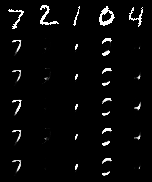

In [5]:
# Visualize the results

from multivae.metrics import Visualization, VisualizationConfig

vis_config = VisualizationConfig(
    n_samples=5, 
    n_data_cond=5
)

vis_module = Visualization(
    model=model,
    test_dataset=testset,
    eval_config=vis_config
)
    
vis_module.reconstruction('images')


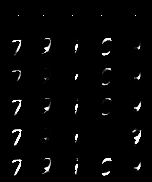

In [6]:
# Generate new images using only the labels and sampling from the prior
vis_module.conditional_samples_subset(['labels'], gen_mod='images')

torch.Size([10, 1, 28, 28])


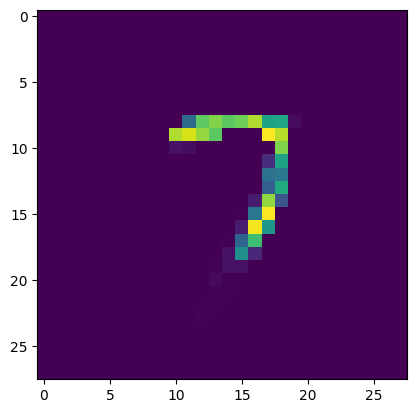

In [14]:
# You can also use your own script for visualization and only the encode /decode /predict functions of the model
samples = testset[:10]

# compute embeddings 
embeddings = model.encode(samples)

# compute reconstructions
output = model.predict(samples, cond_mod='images') 

print(output.reconstruction.shape)

# Example script to visualize the first reconstruction

# import matplotlib.pyplot as plt
# recon = output.reconstruction[0].detach().cpu().numpy()
# plt.imshow(recon[0])


## Training a CVAE using your own architectures


In [5]:
# define your encoder architecture
from multivae.models.nn.base_architectures import BaseJointEncoder, ModelOutput
import torch

class my_encoder(BaseJointEncoder):
    
    def __init__(self, latent_dim):
        super().__init__()
        
        self.latent_dim = latent_dim
        
        self.network = torch.nn.Sequential(
            torch.nn.Linear(10+28*28,512),
            torch.nn.ReLU(),
            torch.nn.Linear(512,512),
            torch.nn.ReLU())
        
        self.embedding = torch.nn.Linear(512,latent_dim)
        self.log_var = torch.nn.Linear(512,latent_dim)
        
        
        
    def forward(self, inputs:dict):
        
        
        images = inputs['images'].view(-1,28*28)
        labels = inputs['labels'].view(-1, 10)
        
        concat = torch.cat([images, labels], dim=1)
        h = self.network(concat)
        
        output = ModelOutput()
        output['embedding'] = self.embedding(h)
        output['log_covariance'] = self.log_var(h)
        
        return output
        
        
        

Pass your encoder to the model and then train it !

In [6]:
from multivae.models import CVAE, CVAEConfig

model_config = CVAEConfig(
    latent_dim=16,
    input_dims=dict(images=(1, 28, 28), labels=(10,)),
    conditioning_modality='labels',
    main_modality='images',
    decoder_dist='bernoulli'
)
    
model = CVAE(model_config, encoder=my_encoder(latent_dim=16))

In [7]:
from multivae.trainers import BaseTrainer, BaseTrainerConfig

trainer_config = BaseTrainerConfig(
    output_dir='/Users/agathe/dev/expes',
    learning_rate=1e-3,
    per_device_eval_batch_size=128,
    per_device_train_batch_size=128,
    num_epochs=1)

trainer=BaseTrainer(
    model=model,
    train_dataset=trainset,
    eval_dataset=evalset,
    training_config=trainer_config
    
)

trainer.train()

Model passed sanity check !
Ready for training.

Setting the optimizer with learning rate 0.001
Created /Users/agathe/dev/expes/CVAE_training_2025-01-17_18-02-35. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 1
 - per_device_train_batch_size: 128
 - per_device_eval_batch_size: 128
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !

Eval of epoch 1/1: 100%|██████████| 94/94 [00:02<00:00, 35.92batch/s]
--------------------------------------------------------------------------
Train loss: 205858.7144
Eval loss: 51046.1335
--------------------------------------------------------------------------
Training ended!
Saved final model in /Users/agathe/dev/expes/CVAE_training_2025-01-